In [181]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from sqlite3 import connect
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from astroquery.vizier import Vizier
import pandas as pd
import sqlite3
import numpy as np
from collections import defaultdict
from os import path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as plp
import joblib
import lamy
from matplotlib.patches import Ellipse, Circle
from pathlib import Path

import Image_module as im

## Чтение fits файла, определение центра и углового размера снятого поля, загрузка каталога снимка

Проверка отработки для пяти объектов:

In [182]:
c1 = SkyCoord('12:32:48.7171 -1:29:22.243', unit=(u.hourangle, u.deg)) #AT2021lfa
c2 = SkyCoord('15:21:25.48 68:20:34.0', unit=(u.hourangle, u.deg)) #150818A
c3 = SkyCoord('16:15:46.6130 +14:23:07.714', unit=(u.hourangle, u.deg)) #210610B_R
c4 = SkyCoord('1:48:07.2695 -6:20:49.995', unit=(u.hourangle, u.deg)) #210722A_r
c5 = SkyCoord('129.8925066 79.2215748', unit=(u.deg, u.deg)) #210912a

circle1 = 1
circle2 = 5
circle3 = 4.514
circle4 = 11.879
circle5 = 0.851

objects = {1: (c1.ra.value, c1.dec.value, circle1),
           2: (c2.ra.value, c2.dec.value, circle2),
           3: (c3.ra.value, c3.dec.value, circle3),
           4: (c4.ra.value, c4.dec.value, circle4),
           5: (c5.ra.value, c5.dec.value, circle5)}

Выбор события

In [783]:
n = 1
obj = objects[n]
           
fits_name = 'test' + str(n) + '.fits'
im_db_path = 'test' + str(n) + '.db'
obj

(188.20298791666664, -1.4895119444444445, 1)

Первый объект - фильтр r; центр (188.19982497, -1.49268559); квадрат (22.04, 22.04); (PS, SDSS), координаты объекта
(188.20298792, -1.48951194)

Второй объект - фильтр R; центр (230.28175944, 68.38398499); квадрат (18.29, 18.29); (PS); координаты объекта
(230.35616667, 68.34277778)

Третий объект - фильтр R; центр (243.88638324, 14.41489765); квадрат (18.29, 18.29); (PS, SDSS); координаты объекта
(243.94422083, 14.38547611)

Четвёртый объект - фильтр r; центр(27.03028958333333, -6.347220833333333); квадрат (22.06, 22.06); координаты объекта
(27.03382825, -6.346988)

Пятый объект - фильтр r; центр(129.89651801, 79.22134282); квадрат (13.56, 13.56); координаты объекта
(129.8925066, 79.2215748)

In [784]:
img = im.imread(fits_name)
w = WCS(img.hdr)

field_center = SkyCoord(*w.wcs.crval, unit = [u.deg, u.deg])
region_width = img.width * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[0]
region_height = img.height * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[1]

cat_db_path = 'catalogs.db' 
eps = 1 #input("Введите значение epsilon")
model = 'Maidanak' #input("Выберите название обсерватории")

# print(field_center)
# print(region_width/60, region_height/60)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [785]:
if not path.isfile(im_db_path):
        raise IOError(f"No such file \"{im_db_path}\"")
        
con1 = sqlite3.connect(im_db_path)
df1 = pd.read_sql_query("SELECT * from objects", con1)[['ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']]


df1.rename(columns={df1.columns[0]: 'RA1',
                    df1.columns[1]: 'e_RA1',
                    df1.columns[2]: 'DE1',
                    df1.columns[3]: 'e_DE1',
                    df1.columns[4]: 'r1',
                    df1.columns[5]: 'e_r1'}, inplace=True)

if fits_name == 'test2' or 'test3':
    df1.r1 += 0.21


df1

,RA1,e_RA1,DE1,e_DE1,r1,e_r1
0,187.990416102568,0.005057,-1.34337177398464,0.007076,13.523146,0.085988
1,187.992885114294,1.502449,-1.35578648381857,1.688250,21.147539,0.133722
2,187.995464776883,0.433014,-1.37032560910434,0.606173,20.333571,0.101317
3,187.998126782129,7.854701,-1.35080854770134,10.990025,20.838474,0.114701
4,187.999016169859,0.605724,-1.39665097046421,0.848311,20.918145,0.110413
...,...,...,...,...,...,...
1968,188.402057237663,0.063886,-1.62852446223497,0.076902,19.878124,2.204601
1969,188.404570605031,0.100146,-1.61537881754912,0.115736,20.240113,2.204767
1970,188.405363729061,0.000000,-1.63930914913251,0.000000,20.385395,2.204864
1971,188.405444729276,0.076628,-1.63928804028764,0.107085,19.594960,2.204521


### 1. Удалённый каталог

In [786]:
catalogs = {'sdss': 'V/147/sdss12', 'ps': 'II/349/ps1'}

sdss_columns_to_import = ['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'class', 'gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag']
ps_columns_to_import = ['RAJ2000', 'e_RAJ2000', 'DEJ2000', 'e_DEJ2000', 'gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag']

columns_to_import = {'sdss': sdss_columns_to_import, 'ps':ps_columns_to_import}
cat_name = 'ps'

In [787]:
%%time

try: 
    outer_cat = Vizier(catalog=catalogs[cat_name], columns=columns_to_import[cat_name], row_limit=-1).query_region(field_center,
                                                        width=region_width + 4/60*u.deg,
                                                        height=region_height + 4/60*u.deg)[0]
except IndexError:
    print('Указанного поля нет в каталоге')

Wall time: 174 ms


In [788]:
df2 = pd.DataFrame()

for  i in columns_to_import[cat_name]:
    df2[i] = outer_cat[i].value

In [789]:
if cat_name == 'ps':  
    
    df2.rename(columns={df2.columns[0]: 'RA2',
                        df2.columns[1]: 'e_RA2',
                        df2.columns[2]: 'DE2',
                        df2.columns[3]: 'e_DE2',
                        df2.columns[4]: 'g2',
                        df2.columns[5]: 'e_g2',
                        df2.columns[6]: 'r2',
                        df2.columns[7]: 'e_r2',
                        df2.columns[8]: 'i2',
                        df2.columns[9]: 'e_i2',
                        df2.columns[10]: 'z2',
                        df2.columns[11]: 'e_z2'}, inplace=True)
    
else:
    pass

if cat_name == 'sdss':
    
    df2.rename(columns={df2.columns[0]: 'RA2',
                        df2.columns[1]: 'e_RA2',
                        df2.columns[2]: 'DE2',
                        df2.columns[3]: 'e_DE2',
                        df2.columns[4]: 'Class',
                        df2.columns[5]: 'g2',
                        df2.columns[6]: 'e_g2',
                        df2.columns[7]: 'r2',
                        df2.columns[8]: 'e_r2',
                        df2.columns[9]: 'i2',
                        df2.columns[10]: 'e_i2',
                        df2.columns[11]: 'z2',
                        df2.columns[12]: 'e_z2'}, inplace=True)
else:
    pass

In [790]:
df2

,RA2,e_RA2,DE2,e_DE2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,188.325973,0.0818,-1.704784,0.0818,NaN,NaN,NaN,NaN,21.6410,0.0153,21.0920,0.2210
1,188.327129,0.0339,-1.701004,0.0342,21.6165,0.1515,21.6359,0.0767,20.9182,0.0459,20.5741,0.0735
2,188.283283,0.0573,-1.707915,0.0573,NaN,NaN,NaN,NaN,21.0656,0.0999,20.8918,0.1273
3,188.280048,0.0638,-1.706350,0.0302,12.7100,NaN,12.3050,NaN,12.1370,NaN,12.0620,NaN
4,188.276814,0.0089,-1.703709,0.0089,17.5081,0.1005,NaN,NaN,18.4041,0.0959,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3993,188.237235,0.0860,-1.279913,0.0860,NaN,NaN,21.7781,0.1611,21.5698,0.1815,21.3314,0.1679
3994,188.237228,0.0616,-1.280105,0.0616,NaN,NaN,21.5185,0.1373,21.4500,0.0792,NaN,NaN
3995,188.238407,0.0621,-1.284536,0.0613,NaN,NaN,21.6272,0.0538,21.4702,0.1296,21.4311,0.1746
3996,188.190843,0.0948,-1.281908,0.0948,NaN,NaN,NaN,NaN,21.2060,0.0990,21.2997,0.1552


### 2. Локальный каталог

In [791]:
# %%time

# if not path.isfile(cat_db_path):
#         raise IOError(f"No such file \"{cat_db_path}\"")
        
# con2 = sqlite3.connect(cat_db_path)

# df2 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat_name, cat_name + '_RA',cat_name + '_DE'),
#                         con2,
#                         params = [field_center.ra.value - region_width.value/7200 - 1/60,
#                                   field_center.ra.value + region_width.value/7200 + 1/60,
#                                   field_center.dec.value - region_height.value/7200 - 1/60,
#                                   field_center.dec.value + region_height.value/7200 + 1/60])

# if cat_name == 'ps':  
    
#     df2.rename(columns={df2.columns[1]: 'RA2',
#                         df2.columns[2]: 'e_RA2',
#                         df2.columns[3]: 'DE2',
#                         df2.columns[4]: 'e_DE2',
#                         df2.columns[5]: 'g2',
#                         df2.columns[6]: 'e_g2',
#                         df2.columns[7]: 'r2',
#                         df2.columns[8]: 'e_r2',
#                         df2.columns[9]: 'i2',
#                         df2.columns[10]: 'e_i2',
#                         df2.columns[11]: 'z2',
#                         df2.columns[12]: 'e_z2',
#                         df2.columns[13]: 'y2',
#                         df2.columns[14]: 'e_y2'}, inplace=True)
# else:
#     pass

# if cat_name == 'sdss':
    
#     df2.rename(columns={df2.columns[1]: 'RA2',
#                         df2.columns[2]: 'e_RA2',
#                         df2.columns[3]: 'DE2',
#                         df2.columns[4]: 'e_DE2',
#                         df2.columns[5]: 'u2',
#                         df2.columns[6]: 'e_u2',
#                         df2.columns[7]: 'g2',
#                         df2.columns[8]: 'e_g2',
#                         df2.columns[9]: 'r2',
#                         df2.columns[10]: 'e_r2',
#                         df2.columns[11]: 'i2',
#                         df2.columns[12]: 'e_i2',
#                         df2.columns[13]: 'z2',
#                         df2.columns[14]: 'e_z2'}, inplace=True)
# else:
#     pass

# df2

In [792]:
obj_coord = SkyCoord(obj[0]*u.deg, obj[1]*u.deg)
df1_coord = SkyCoord(df1.iloc[:, 0].values.astype(float).tolist(), df1.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")
df2_coord = SkyCoord(df2.iloc[:, 0].values.astype(float).tolist(), df2.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")

## Визуализация событий 

Соседи в каталоге изображения

In [793]:
seplimit = 15*u.arcsec
df1_cp_id = obj_coord.separation(df1_coord) < seplimit
df1_cp = df1.iloc[df1_cp_id].copy()

# Расстояния
df1_cp['sep'] = obj_coord.separation(df1_coord).to(u.arcsec)[df1_cp_id].value
df1_cp

,RA1,e_RA1,DE1,e_DE1,r1,e_r1,sep
1026,188.203039046218,0.116334,-1.48947962158306,0.162575,20.205963,0.139593,0.21771


In [794]:
obj_loc_df1 = SkyCoord.match_to_catalog_sky(obj_coord, df1_coord)
obj_df1 = df1.loc[obj_loc_df1[0]]

print('Событие в каталоге изображения:')
obj_df1

Событие в каталоге изображения:


RA1       188.203039046218
e_RA1             0.116334
DE1      -1.48947962158306
e_DE1             0.162575
r1               20.205963
e_r1              0.139593
Name: 1026, dtype: object

Соседи во втором каталоге

In [795]:
seplimit = 15*u.arcsec
df2_cp_id = obj_coord.separation(df2_coord) < seplimit
df2_cp = df2.iloc[df2_cp_id].copy()

# Расстояния
df2_cp['sep'] = obj_coord.separation(df2_coord).to(u.arcsec)[df2_cp_id].value
df2_cp

,RA2,e_RA2,DE2,e_DE2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,sep
2142,188.201316,0.074,-1.493134,0.074,NaN,NaN,22.1086,0.0034,21.5832,0.0073,21.1052,0.3539,14.360882


Ближайший

In [796]:
obj_df1_coord = SkyCoord(float(obj_df1.RA1)*u.deg, float(obj_df1.DE1)*u.deg)

obj_df1_loc_df2 = SkyCoord.match_to_catalog_sky(obj_df1_coord, df2_coord)

print('До ближайшего соседа во внешнем каталоге {} угл. секунд, этот объект:'.format(np.round(obj_df1_loc_df2[1].value[0]*3600, 2)))
df2.iloc[obj_df1_loc_df2[0]]

До ближайшего соседа во внешнем каталоге 14.54 угл. секунд, этот объект:


RA2      188.201316
e_RA2      0.074000
DE2       -1.493134
e_DE2      0.074000
g2              NaN
e_g2            NaN
r2        22.108600
e_r2       0.003400
i2        21.583200
e_i2       0.007300
z2        21.105200
e_z2       0.353900
Name: 2142, dtype: float64

Отображение id

In [797]:
sep = 25*u.arcsec

im_cent = df1.loc[obj_coord.separation(df1_coord) < sep]
cat_cent = df2.loc[obj_coord.separation(df2_coord) < sep]

im_cent_sk  = SkyCoord(im_cent.iloc[:, 0].values.astype(float).tolist(), im_cent.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")
cat_cent_sk = SkyCoord(cat_cent.iloc[:, 0].values.astype(float).tolist(), cat_cent.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")

im_text = np.array((im_cent.index), dtype = str)
cat_text = np.array((cat_cent.index), dtype = str)

Минимум: 719, максимум: 64160, медиана: 758.0


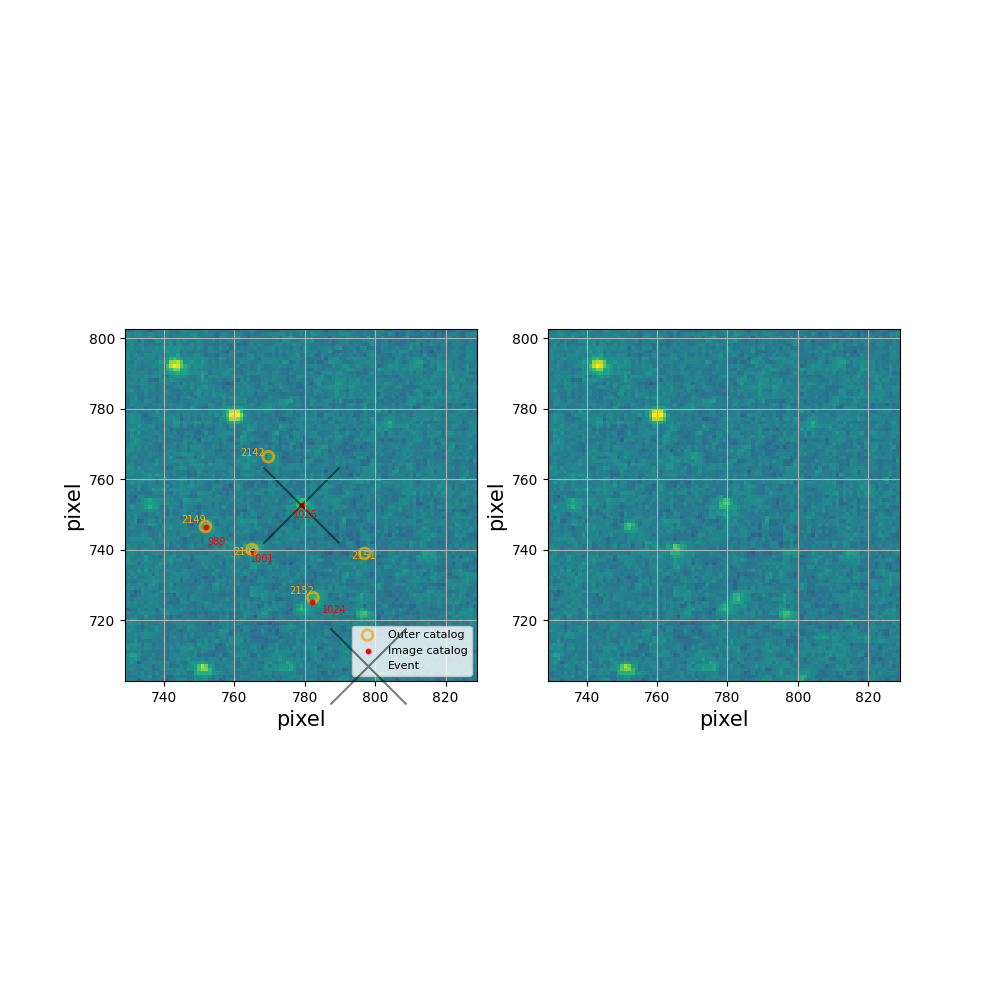

In [798]:
%matplotlib ipympl
import scipy.stats as st

q = st.chi2(df=2).ppf(.99997)
delta = 50

fig, [ax, ax1] = plt.subplots(1, 2, figsize=(10,10))

#Центрируем на событие
cent = np.array((w.world_to_pixel(obj_coord)[0], w.world_to_pixel(obj_coord)[1]))

# объекты из каталога
ax.scatter(w.world_to_pixel(cat_cent_sk)[0], w.world_to_pixel(cat_cent_sk)[1], s=60, marker='o', label='Outer catalog', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   facecolors='none',
                   alpha=0.75)

for i in range(len(cat_text)):
    ax.annotate(cat_text[i],  (w.world_to_pixel(cat_cent_sk[i])[0] - np.random.rand()*6 - 3, w.world_to_pixel(cat_cent_sk[i])[1] + np.random.rand()*6 - 3), c = 'orange', size=7, alpha=1)
    
    
#объекты с изображения
ax.scatter(w.world_to_pixel(im_cent_sk)[0], w.world_to_pixel(im_cent_sk)[1], s=10, color='r', label='Image catalog')

for i in range(len(im_text)):
    ax.annotate(im_text[i],  (w.world_to_pixel(im_cent_sk[i])[0] + np.random.rand()*6 - 3, w.world_to_pixel(im_cent_sk[i])[1] - np.random.rand()*6 - 3), c = 'r', size=7, alpha=1)
    
    
    
ax.scatter(w.world_to_pixel(obj_coord)[0], w.world_to_pixel(obj_coord)[1], color='k', marker="x", alpha=.5, label='Event', s=3000)

thr = img.data.mean() - img.data.min() 
m = np.median(img.data)

ax.imshow(img.data, vmin=img.data.min(), vmax=m + thr)
ax1.imshow(img.data, vmin=img.data.min(), vmax=m + thr)

ax.set_xlim(cent[0] - delta, cent[0] + delta)
ax1.set_xlim(cent[0] - delta, cent[0] + delta)

ax.set_ylim(cent[1] - delta, cent[1] + delta)
ax1.set_ylim(cent[1] - delta, cent[1] + delta)

ax.set_xlabel('pixel', fontsize=15)
ax.set_ylabel('pixel', fontsize=15)
ax1.set_xlabel('pixel', fontsize=15)
ax1.set_ylabel('pixel', fontsize=15)

ax.grid()
ax1.grid()
ax.legend(loc=4,prop={'size': 8})

# plt.savefig('first slide.png')
print('Минимум: {}, максимум: {}, медиана: {}'.format(img.data.min(), img.data.max(), np.median(img.data)))

## Сопоставление

In [799]:
%%time

nnbs = SkyCoord.match_to_catalog_sky(df1_coord, df2_coord)
eps=2

Wall time: 18 ms


Группа a0: каждый объект с изображения нашёл соседа в eps, и этот сосед не сопоставлен ни с кем другим

In [800]:
temp_ar = nnbs[1].to(u.arcsec).value < eps

temp_df = df1.loc[temp_ar].copy()
temp_df['id2'] = nnbs[0][temp_ar]

a0 = temp_df.loc[~temp_df.id2.duplicated(keep=False)].copy()
a0.reset_index(drop=False, inplace=True)
a0.rename(columns={'index': 'id1'}, inplace=True)

print('Всего объектов: {}, объектов в a0: {}'.format(len(df1), len(a0)))

Всего объектов: 1973, объектов в a0: 1392


Группа a1: объект никого не нашёл в eps

In [801]:
temp_ar = nnbs[1].to(u.arcsec).value > eps

a1 = df1.loc[temp_ar].copy()

print('Всего объектов: {}, объектов в a1: {}'.format(len(df1), len(a1)))

Всего объектов: 1973, объектов в a1: 473


Группа a2: более одного объекта с изображения сопоставляются с одним и тем же объектом в каталоге 

In [802]:
temp_ar = nnbs[1].to(u.arcsec).value < eps

temp_df = df1.loc[temp_ar].copy()
temp_df['id2'] = nnbs[0][temp_ar]

a2= temp_df.loc[temp_df.id2.duplicated(keep=False)].copy()
a2.reset_index(drop=False, inplace=True)
a2.rename(columns={'index': 'id1'}, inplace=True)

print('Всего объектов: {}, объектов в a2: {}'.format(len(df1), len(a2)))

Всего объектов: 1973, объектов в a2: 108


In [803]:
print(len(a0) + len(a1) + len(a2) == len(df1))

True


Работа с группой a1: для каждого объекта в расширенном радиусе (~20arcsec) запускаем сопоставление по блеску. Если находим компаньон, проверяем, чтобы его не было в группе a0

In [804]:
noid_coord = SkyCoord(a1.iloc[:, 0].values.astype(float).tolist(), a1.iloc[:, 2].values.astype(float).tolist(), frame="icrs", unit="deg")
res = search_around_sky(noid_coord, df2_coord, seplimit=20*u.arcsec)

temp_df_1 = a1.iloc[res[0]].copy()
temp_df_1.reset_index(drop=False, inplace=True)
temp_df_1.rename(columns={'index': 'id1'}, inplace=True)


temp_df_2 = df2.iloc[res[1]].copy()
temp_df_2.reset_index(drop=False, inplace=True)
temp_df_2.rename(columns={'index': 'id2'}, inplace=True)

preprod1 = pd.concat([temp_df_1, temp_df_2], axis=1)
preprod1['sep'] = res[2].value*3600

#Сопоставление по магнитудам
phm_test = preprod1.apply(lamy.photometry_test, axis = 1, args = (model, ))
preprod1['phm_test'] = phm_test
preprod1

,id1,RA1,e_RA1,DE1,e_DE1,r1,e_r1,id2,RA2,e_RA2,...,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,sep,phm_test
0,1,187.992885114294,1.502449,-1.35578648381857,1.688250,21.147539,0.133722,3655,187.994119,0.0590,...,NaN,NaN,21.4164,0.1632,20.8704,0.1786,20.4922,0.0945,17.174798,False
1,1,187.992885114294,1.502449,-1.35578648381857,1.688250,21.147539,0.133722,3658,187.991663,0.0088,...,18.3089,0.0043,18.0153,0.0033,17.9091,0.0068,17.8912,0.0054,15.304649,False
2,1,187.992885114294,1.502449,-1.35578648381857,1.688250,21.147539,0.133722,3660,187.994049,0.0285,...,21.9428,0.2365,21.7344,0.0972,20.9368,0.0378,20.4032,0.0718,17.103772,True
3,3,187.998126782129,7.854701,-1.35080854770134,10.990025,20.838474,0.114701,3652,188.000685,0.0714,...,NaN,NaN,21.2616,0.1944,20.6839,0.0814,NaN,NaN,14.402689,False
4,3,187.998126782129,7.854701,-1.35080854770134,10.990025,20.838474,0.114701,3655,187.994119,0.0590,...,NaN,NaN,21.4164,0.1632,20.8704,0.1786,20.4922,0.0945,14.486329,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,1958,188.393361497813,0.553573,-1.64282074274228,0.773243,20.523236,2.376424,1203,188.396901,0.0322,...,21.9059,0.0414,20.9146,0.0569,20.4745,0.0184,20.0534,0.0363,13.520308,False
953,1958,188.393361497813,0.553573,-1.64282074274228,0.773243,20.523236,2.376424,1210,188.389843,0.0407,...,21.9696,0.0946,21.4770,0.0736,21.0986,0.0542,20.8732,0.0285,17.105912,False
954,1958,188.393361497813,0.553573,-1.64282074274228,0.773243,20.523236,2.376424,1217,188.390244,0.0280,...,20.7829,0.0258,19.6038,0.0227,18.7235,0.0131,18.2557,0.0141,11.687680,False
955,1966,188.401424896036,0.000000,-1.61214696921092,0.000000,20.394262,2.204876,1237,188.404662,0.0260,...,22.2123,0.1857,21.4599,0.0691,20.8095,0.0486,20.5054,0.0355,16.764140,False


In [805]:
found = preprod1.loc[preprod1.phm_test == True]
rel = found.loc[found.id2.isin(a0.id2.values) == False]

#Выбираем взаимно-однозначные сопоставления по блеску
temp_rel = rel.loc[~rel.id1.duplicated(keep=False)]
relevant = temp_rel.loc[~temp_rel.id2.duplicated(keep=False)]
relevant

,id1,RA1,e_RA1,DE1,e_DE1,r1,e_r1,id2,RA2,e_RA2,...,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,sep,phm_test
2,1,187.992885114294,1.502449,-1.35578648381857,1.688250,21.147539,0.133722,3660,187.994049,0.0285,...,21.9428,0.2365,21.7344,0.0972,20.9368,0.0378,20.4032,0.0718,17.103772,True
13,5,187.999256458139,0.532886,-1.40376904859222,0.490235,20.967038,0.122435,3626,187.998888,0.0694,...,22.0626,0.1416,21.6850,0.0634,21.3760,0.1942,21.3373,0.1660,2.227531,True
22,33,188.014285158929,0.627492,-1.46655597377263,0.879649,20.314208,0.068481,3053,188.014340,0.0794,...,NaN,NaN,20.4008,0.0780,20.4168,0.1434,NaN,NaN,18.370500,True
63,90,188.029822862657,0.000000,-1.5881201290822,0.000000,21.012911,0.160115,912,188.027815,0.0292,...,22.1392,0.0946,21.3673,0.0449,20.8294,0.0964,20.6539,0.0392,16.757670,True
89,115,188.035964981285,0.255192,-1.35288514881942,0.280867,20.377728,0.087504,3676,188.038144,0.0168,...,21.8200,0.0564,21.0626,0.0673,20.7618,0.0411,20.4660,0.0325,8.931935,True
209,313,188.069974639552,3.083713,-1.35575538587231,4.318313,20.471479,0.107065,3374,188.074709,0.0197,...,21.9252,0.0693,20.8842,0.0267,19.8156,0.0102,19.3247,0.0149,19.326367,True
327,572,188.11817332184,0.000000,-1.32117094954602,0.000000,21.444226,0.122188,3820,188.114224,0.0131,...,22.8637,0.2730,21.4518,0.0596,20.2402,0.0284,19.6542,0.0128,18.589107,True
344,618,188.124362513126,0.225713,-1.31928292545998,0.633347,20.926210,0.089052,3546,188.129646,0.0591,...,21.8789,0.0816,21.8911,0.0874,21.4821,0.0599,20.6657,0.0413,19.958638,True
368,665,188.132673319771,3.007423,-1.68786247662682,1.205008,20.383470,0.054185,130,188.135726,0.0362,...,20.8335,0.0798,20.8181,0.0878,21.3389,0.0553,NaN,NaN,11.040879,True
396,710,188.142940019803,0.214342,-1.53703486356258,0.299602,20.607325,0.148962,2088,188.143773,0.0496,...,21.5676,0.0980,21.3068,0.0798,20.9329,0.0584,20.5597,0.1226,12.971266,True


Работа с группой a2: для каждого объекта 1 из пар дубликатов (одному объекту из внеш. каталога оказались сопоставлены два и более объектов с изображения) и сопоставленного ему объекта проводим два теста: первый тест использует указанные в каталогах ошибки локализации объектов и проверяет гипотезу о том, что пара - один и тот же объект, второй тест - обученная модель для классификации объектов по блеску. В каждом из тестов: True объекты следует сопоставить, False - сопоставление следует отклонить. Все пары, имеющие меньше двух True отправляются в группу кандидатов. Пары с идентичными координатами группируются.

Дубликаты

In [806]:
preprod_dup = a2.join(df2, on='id2').copy()


preprod_dup['sep'] = preprod_dup.apply(lamy.separation, axis = 1)
preprod_dup['position_test'] = preprod_dup.apply(lamy.position_test, axis = 1, args = (0.99997, ))
preprod_dup['photometry_test'] = preprod_dup.apply(lamy.photometry_test, axis = 1, args = (model, ))


# prod = preprod.copy()
# prod['tests_sum'] = 1*prod['position_test'] + 1*prod['photometry_test']
# prod
preprod_dup['sum'] = 1*preprod_dup['position_test'] + 1*preprod_dup['photometry_test']

In [807]:
prod = preprod_dup.loc[preprod_dup['sum'] < 2]
a22 = prod.loc[~prod.RA1.duplicated(keep='first')].iloc[:, :8]

In [808]:
preprod_dup_a0 = preprod_dup.loc[preprod_dup['sum'] == 2]
preprod_dup_a0.reset_index(drop=True, inplace=True)

Сшиваем идентифицировавшихся

In [809]:
a00 = pd.concat([a0, preprod_dup_a0.iloc[:, :8]], ignore_index=True)

In [810]:
a000 = pd.concat([a00, relevant.iloc[:, :8]], ignore_index=True)

Не потерялось ли событие?

In [811]:
pd.Series(obj_df1.name).isin(a000.id1)

0    False
dtype: bool

In [812]:
candidates = df1.loc[~df1.index.isin(a000.id1)]
candidates

,RA1,e_RA1,DE1,e_DE1,r1,e_r1
2,187.995464776883,0.433014,-1.37032560910434,0.606173,20.333571,0.101317
3,187.998126782129,7.854701,-1.35080854770134,10.990025,20.838474,0.114701
4,187.999016169859,0.605724,-1.39665097046421,0.848311,20.918145,0.110413
6,188.000430693676,0.445598,-1.36590739653148,0.623707,20.346704,0.099567
16,188.003925164606,0.287365,-1.43172843741522,1.281178,21.419434,0.162724
...,...,...,...,...,...,...
1961,188.394703397214,0.167995,-1.60674065537863,0.234981,20.417064,2.204951
1966,188.401424896036,0.000000,-1.61214696921092,0.000000,20.394262,2.204876
1970,188.405363729061,0.000000,-1.63930914913251,0.000000,20.385395,2.204864
1971,188.405444729276,0.076628,-1.63928804028764,0.107085,19.594960,2.204521
